In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import Ridge

### Guidelines for data plotting

When asked to produce a plot, you must:

1. Follow directions on whether to use a line plot or scatter plot
2. Provide descriptive labels for all axes and give units when indicated
3. Provide a descriptive title for the plot
4. Provide a descriptive legend for the plot when plotting more than one dataset
5. Use color or marker to differentiate between datasets when plotting more than one dataset

### Guidelines for report numerical and text-based answers

1. When asked to report a numerical value (e.g. a validation score), you must include a print statement that describes the value being reported either together or directly before the printing of the value itself.

2. When asked to answer a question with text, create a new text cell and answer the question in complete sentances.

## 1. Ridge Regression - Air Quality Chemical Multisensor Calibration

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Ground Truth hourly averaged concentrations for CO, Non Methanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. **Missing values are tagged with -200 value.**

```
Attribute information:

0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)
2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4 True hourly averaged overall Non Methanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7 True hourly averaged NOx concentration in ppb (reference analyzer)
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12 Temperature in Â°C
13 Relative Humidity (%)
14 AH Absolute Humidity
```

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
!unzip AirQualityUCI.zip

--2023-03-08 03:36:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543989 (1.5M) [application/x-httpd-php]
Saving to: ‘AirQualityUCI.zip’

AirQualityUCI.zip   100%[===================>]   1.47M  7.78MB/s    in 0.2s    

2023-03-08 03:36:09 (7.78 MB/s) - ‘AirQualityUCI.zip’ saved [1543989/1543989]

Archive:  AirQualityUCI.zip
  inflating: AirQualityUCI.csv       
  inflating: AirQualityUCI.xlsx      


In [ ]:
df = pd.read_excel('AirQualityUCI.xlsx')
df = df.dropna()

#### Step 1: Visualize dataset

In the next steps of this homework problem, we will focus on the prediction of airborne benzene concentration as a function of the non-methanic hydrocarbon sensor reading and meteorological variables.

**Construct a correlation heatmap plot**. Include the `PT08.S2(NMHC)`, `T`, `RH`, and `AH` data as features. Use the `C6H6(GT)` data as the prediction task. Be sure to remove examples containing missing values.

**Answer the following questions**:

1. What feature variable(s) have the highest correlation with the task variable (`C6H6(GT)`)?
2. What feature variable(s) have the lowest correlation with the task variable?
3. Are there any feature variables that are correlated to one-another i.e. r>0.5 or r<-0.5 (i.e. negative correlation)?

               PT08.S2(NMHC)         T        RH        AH  C6H6(GT)
PT08.S2(NMHC)       1.000000  0.668984  0.585775  0.646535  0.767401
T                   0.668984  1.000000  0.885910  0.980998  0.971370
RH                  0.585775  0.885910  1.000000  0.943997  0.925068
AH                  0.646535  0.980998  0.943997  1.000000  0.984556
C6H6(GT)            0.767401  0.971370  0.925068  0.984556  1.000000


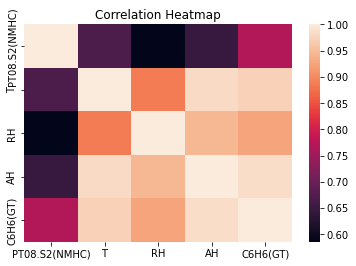

In [ ]:
features = ['PT08.S2(NMHC)','T','RH','AH']
prediction = 'C6H6(GT)'
corr = df[features + [prediction]].corr()
sns.heatmap(corr)
plt.title("Correlation Heatmap")
print(corr)

1) PT08.S2(NMHC) has the highest correlation
2) RH has the lowest correlation
3) T and AH have a correlation and PT08.S2(NMHC) and AH have a correlation

#### Step 2: Prepare the dataset for modeling

**Split the dataset into features (`X`) and task/labels (`y`). Split the features/labels into training and testing sets.** Include the `PT08.S2(NMHC)`, `T`, `RH`, and `AH` data as features. Use the `C6H6(GT)` data as the prediction task. If you haven't already, remove rows containing missing values.

In [ ]:
x = df[['PT08.S2(NMHC)','T','RH','AH']]
y = df['C6H6(GT)']
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 1234)

#### Step 3: Hyperparameter optimization for Benzene concentration prediction

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.PolynomialFeatures` polynomial feature expansion.
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.linear_model.Ridge` ridge regression model.
2. **Perform a grid search `GridSearchCV`** over
  - `degree`: the degree of the polynomial expansion in `PolynomialFeatures`
  - `alpha`: the regularization penalty strength parameter
3. **Print out the best cross-validation score and corresponding parameters.**

You may select the range of possible hyperparameter values, but you must compare at least 50 total models.

In [ ]:
model = Pipeline([('poly', PolynomialFeatures()),('scaler', StandardScaler()),('ridge', Ridge())])
param = {'poly__degree': [1, 2, 3, 4,5],
    'ridge__alpha': [1,2,3,4,5,6,7,8,9,10]}
clf = GridSearchCV(model,param,cv=5)
clf.fit(x_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

0.999998885268392
{'poly__degree': 4, 'ridge__alpha': 1}


#### Step 4: Visualize the results

**Construct a parity plot comparing the ground truth labels with the model predictions on the test set.** The parity plot should contain (1) a scatter plot showing the ground truth (x-axis) and predictions (y-axis) and (2) a parity line (or, a line where x=y). Be sure to follow all plotting guidelines. Be sure to retrain the best model with the entire training set before evaluating the test set.

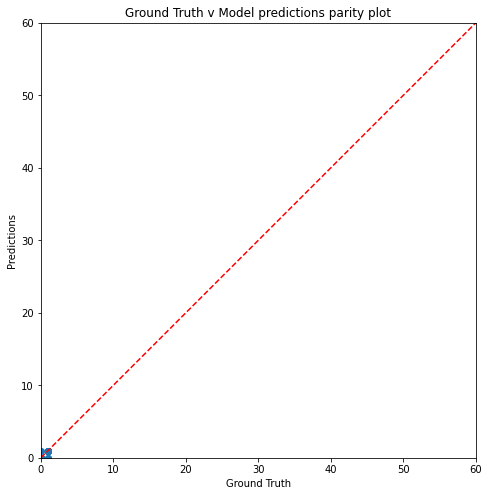

In [ ]:
best = clf.best_estimator_
best.fit(x,y)
y_pred = best.predict(x_test)
fig, parity = plt.subplots(figsize=(8, 8))
parity.scatter(y_test, y_pred)
parity.plot(np.linspace(0, 60), np.linspace(0, 60), '--',c='red')
parity.set_xlabel('Ground Truth')
parity.set_ylabel('Predictions')
parity.set_xlim([0, 60])
parity.set_ylim([0, 60])
parity.set_aspect('equal', adjustable='box')
parity.set_title('Ground Truth v Model predictions parity plot')
plt.show()

#### Step 5: Carbon monoxide concentration prediction

**Repeat steps 2, 3, and 4 of the homework problem in order to build a calibration model for the carbon monoxide (CO) detector.** Practically, this means replace the label array with the data found in the `CO(GT)` column of the original data frame and replacing the feature data `PT08.S2(NMHC)` with the data found in the `PT08.S1(CO)` column of the original data frame.

1. **Prepare the new dataset for model by train/test split.**
2. **Perform hyperparameter optimization over an identical search space.** **Print out the best model score and associated hyperparameters.**
3. **Construct a parity plot comparing the ground truth labels with the model predictions on the test set.**

In [ ]:
x = df['PT08.S1(CO)'].values.reshape(-1, 1)
y = df['CO(GT)'].values
keep = ~np.isnan(y)
x = x[keep]
y = y[keep]
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1234)

In [ ]:
model = Pipeline([('poly', PolynomialFeatures()),('scaler', StandardScaler()),('ridge', Ridge())])
C = np.logspace(-4,4,50)
param = {'poly__degree':[1,2,3,4,5],'ridge__alpha':C}
clf = GridSearchCV(model,param)
clf.fit(x_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

0.016352074315072507
{'poly__degree': 4, 'ridge__alpha': 0.019306977288832496}


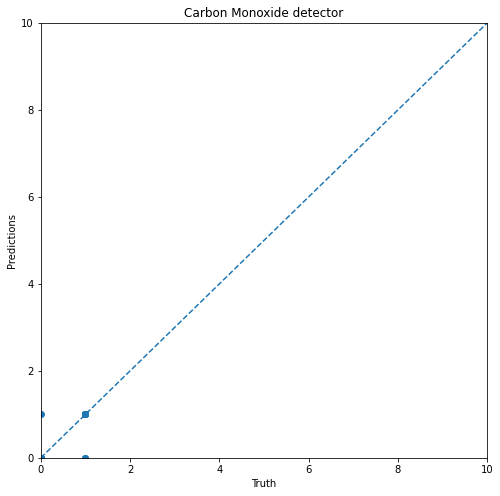

In [ ]:
y_pred = clf.predict(x_test)

fig, parity = plt.subplots(figsize=(8, 8))
parity.scatter(y_test, y_pred)
parity.plot(np.linspace(0, 10), np.linspace(0, 10), '--')
parity.set_xlabel('Truth')
parity.set_ylabel('Predictions')
parity.set_xlim([0, 10])
parity.set_ylim([0, 10])
parity.set_title('Carbon Monoxide detector')
plt.show()

## 2. Logistic Regression - Wisconsin Breast Cancer Dataset
```
Title: Wisconsin Breast Cancer Database (January 8, 1991)

Sources:
   -- Dr. WIlliam H. Wolberg (physician)
      University of Wisconsin Hospitals
      Madison, Wisconsin
      USA
   -- Donor: Olvi Mangasarian (mangasarian@cs.wisc.edu)
      Received by David W. Aha (aha@cs.jhu.edu)
   -- Date: 15 July 1992

Number of Instances: 699 (as of 15 July 1992)

Number of Attributes: 10 plus the class attribute

Attribute Information: (class attribute has been moved to last column)

   #  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)

Missing attribute values: 16

   There are 16 instances in Groups 1 to 6 that contain a single missing
   (i.e., unavailable) attribute value, now denoted by "?".  

Class distribution:

   Benign: 458 (65.5%)
   Malignant: 241 (34.5%)
```

### Step 0: Load dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

--2023-03-01 23:50:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [application/x-httpd-php]
Saving to: ‘breast-cancer-wisconsin.data.1’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.07s   

2023-03-01 23:50:28 (280 KB/s) - ‘breast-cancer-wisconsin.data.1’ saved [19889/19889]



In [ ]:
names = ['Sample code number',
         'Clump thickness',
         'Uniformity of Cell Size',
         'Uniformity of Cell Shape',
         'Marginal Adhesion',
         'Single Epithelial Cell Size',
         'Bare Nuclei',
         'Bland Chromatin',
         'Normal Nucleoli',
         'Mitosis',
         'Class']
df = pd.read_csv('breast-cancer-wisconsin.data', names=names).dropna()
df

,Sample code number,Clump thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


#### Step 1: Visualize dataset

**Construct a pair plot for the breast cancer dataset.** Drop the column `Sample code number` before generating the plot.

<function matplotlib.pyplot.legend(*args, **kwargs)>

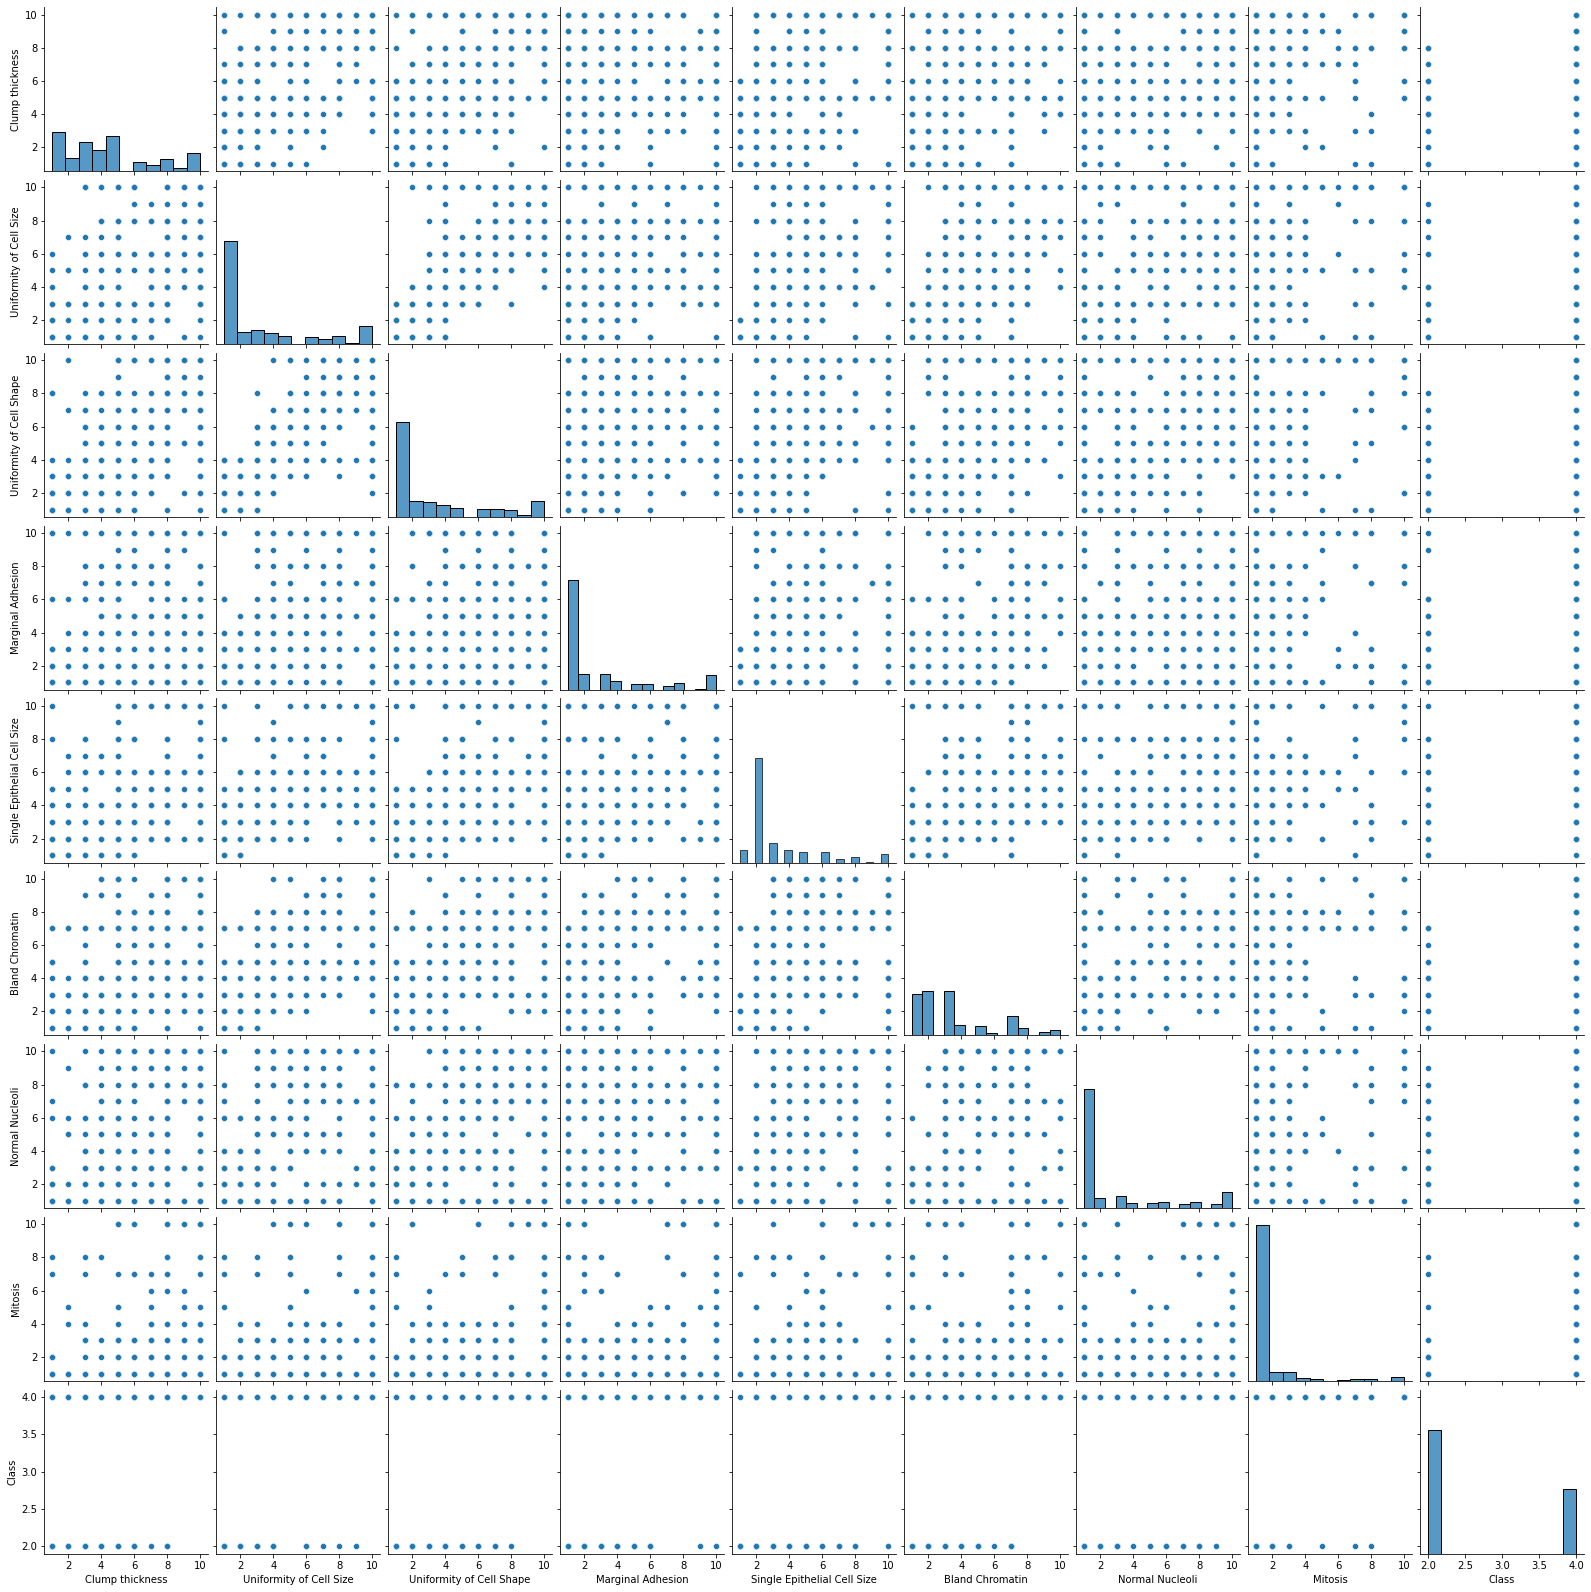

In [ ]:
sns.pairplot(data = df.drop('Sample code number', axis = 1))


#### Step 2: Prepare the dataset for modeling.

1. **Prepare the target data `y` containing the data found in the `Class` column.**
2. **Modify `y` to be suitable for binary classification modeling.** Assign a label of `0` to the benign class, and a label of `1` to the malignant class.
3. **Prepare the design matrix `X` containing the data found in the remaining columns.** Be sure to drop `Class` and `Sample code number` columns before generating `X`. Be sure to properly address any rows with missing values.
4. **Split the dataset into training and testing sets.**

In [ ]:
df.replace('?', np.nan, inplace=True)
df.fillna(df.median(), inplace=True)
y = df['Class'].map({2:0,4:1})
x = df.drop(['Class','Sample code number'],axis = 1).dropna()
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1234)

#### Step 3: Hyperparameter optimization pipeline

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.PolynomialFeatures` polynomial feature expansion.
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.linear_model.LogisticRegression` logistic regression model.
2. **Perform a grid search `GridSearchCV`** over
  - `degree`: the degree of the polynomial expansion in `PolynomialFeatures`
  - `C`: the regularization penalty strength parameter
3. **Print out the best cross-validation score and corresponding parameters.**

I recommend using the `solver='liblinear'` keyword argument. The default `penalty` is `l2`.

In [ ]:
model = Pipeline(steps = [('poly', PolynomialFeatures(degree = 3)),('scale', StandardScaler()),('logreg', LogisticRegression(penalty = 'l2', C=.01,solver='liblinear'))])
parameters = {
    'poly__degree': [1, 2, 3],
    'logreg__C':[.01]
}
clf = GridSearchCV(model,parameters,return_train_score = True)
clf.fit(x_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

0.9656227106227107
{'logreg__C': 0.01, 'poly__degree': 1}


#### Step 3 (cont.)

**Repeat the above analysis but using the argument `penalty='l1'` in the `LogisticRegression` class.** The `l1` penalty penalizes the absolute value of the weight vector as opposed to the `l2` penalty which penalizes the square magnitude. Construct a bar chart showing the magnitude of the linear coefficients `clf.coef_` for the best `l1` and `l2` models. Comment on the qualitative differences between the two plots.

0.9560805860805861
{'logreg__C': 0.01, 'poly__degree': 2}


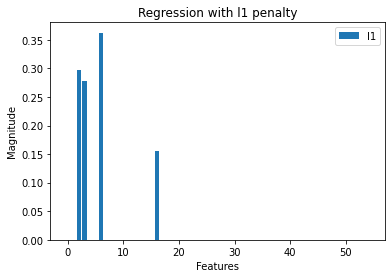

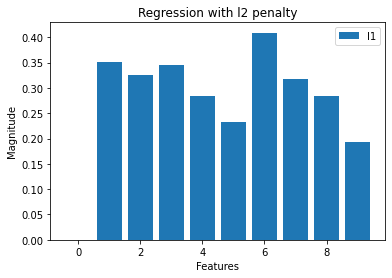

In [ ]:
model_l1 = Pipeline(steps = [('poly', PolynomialFeatures(degree = 3)),('scale', StandardScaler()),('logreg', LogisticRegression(penalty = 'l1', C=.01,solver='liblinear'))])
clf_l1 = GridSearchCV(model_l1,parameters,return_train_score = True)
clf_l1.fit(x_train,y_train)
print(clf_l1.best_score_)
print(clf_l1.best_params_)
l1 = clf_l1.best_estimator_.named_steps['logreg'].coef_[0]
l2 = clf.best_estimator_.named_steps['logreg'].coef_[0]

plt.bar(range(len(l1)), l1, label='l1')
plt.xlabel('Features')
plt.ylabel('Magnitude')
plt.title('Regression with l1 penalty')
plt.legend()
plt.show()

plt.bar(range(len(l2)), l2, label='l1')
plt.xlabel('Features')
plt.ylabel('Magnitude')
plt.title('Regression with l2 penalty')
plt.legend()
plt.show()


#plt.bar(range(len(l2)), l2, label='l2')

#### Step 4: Evaluate the results

Using the best model from step 3, retrain the model on the training set. **Generate a confusion matrix based on ground truth data and predictions of the model on the testing set. Identify the number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) model predictions.**

TP 61
TN 109
FP 2
FN 3


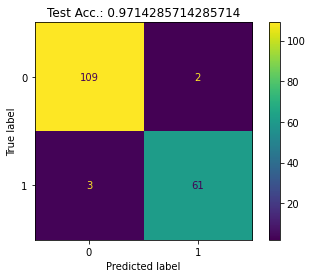

In [ ]:
model = Pipeline(steps = [('poly', PolynomialFeatures(degree = 2)),('scale', StandardScaler()),('logreg', LogisticRegression(penalty = 'l1',solver='liblinear', C=clf.best_params_['poly__degree']))])
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.title(f'Test Acc.: {acc}')
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
print("TP",TP)
print("TN",TN)
print("FP",FP)
print("FN",FN)

#### Step 5: Additional metrics

**Compute the `precision_score`, `selectivity`, and `recall_score` using the ground truth data and model predictions. Comment on the how well we are able to trust positive classifications and negative classifications given by our model.**

In [ ]:
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
select = TN /(TN+FP)
print(precision)
print(recall)
print(select)

0.9682539682539683
0.953125
0.9819819819819819


We are able to trust the classifications, becuase all of the scores are fairly high. No score is below .9, so the classifications are good but there may be some miscalculations.